# Distributed Feature Extraction for Video Classification

In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle
import glob
import cv2
import sys
import os
import time

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
import seaborn as sns

 
# adding video-download folder to the system path
sys.path.insert(0, '/workspace/youtube-humpback-whale-classifier/video-download')
 
# importing read_frames_hdf5 function
from hdf5_data_loading import read_frames_hdf5

#ngc workspace path (where we keep our data)
workspace_path = '/mount/data'

In [2]:
import wandb

#start wandb session for metric logging
wandb.login() 

wandb.init(project="whale-classification-inception")

wandb.run.name = "data aug"

# # !wandb login --relogin

wandb: Currently logged in as: micheller (epg). Use `wandb login --relogin` to force relogin


In [3]:
print("Num GPUs available: ", len(tf.config.list_physical_devices('GPU'))) #1 if we select GPU mode in Colab Notebook, 0 if running on local machine

Num GPUs available:  8


In [4]:
#limit GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

8 Physical GPUs, 8 Logical GPUs


2022-08-05 00:34:11.287156: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 00:34:17.897161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14649 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB-N, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-08-05 00:34:17.899769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14649 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB-N, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-08-05 00:34:17.902225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

## Distributed Feature Extraction

In [ ]:
#load dataset in
data = pd.read_csv(workspace_path + '/downloaded_videos.csv')
y = data.pop('relevant')
X = data

#load in frames for all videos
start = time.time()

N = X.shape[0] #number of videos in our dataset
videos = np.empty((N, 461, 224, 224, 3), dtype=np.uint8)
labels = np.empty(N, dtype = np.uint8)

clip_names = [video.replace("_", "_clip_").replace(".mp4", "") for video in list(X.renamed_title)]

for i, clip_name in enumerate(clip_names):
    if i % 50 == 0:
        print(f'Loading frames for video {i}...')
        
    frames, frame_labels = read_frames_hdf5(clip_name) #returns frames array of shape (461, 224, 224, 3)
    
    videos[i, ...] = frames
    labels[i] = frame_labels[0] #all frames have the same label since label is assigned to overall video

stop = time.time()
print(f'Done loading frames in {stop-start} seconds.')

print(videos.shape)
print(labels.shape)

Loading frames for video 0...
Loading frames for video 50...
Loading frames for video 100...


## Trying out Data Augmentation

In [ ]:
def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
#     images = tf.image.random_flip_up_down(images)
#     images = tf.image.rotate90(images)
    
    return (images, labels)

# !pip install scikit-image
from skimage.transform import rotate
from scipy.ndimage import gaussian_filter

def augment_numpy(video):
    video = [np.flipud(image) for image in video] #vertical flip
    video = [np.fliplr(image) for image in video] #horizontal flip
    video = [rotate(image, 35) for image in video] #rotate
    video = [gaussian_filter(image, sigma=1, order=0) for image in video]
    return video

data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip(seed=43),
        keras.layers.RandomRotation(0.1, seed=43),
        keras.layers.RandomZoom(0.2, seed=43),
    ]
)


In [96]:
# Create Datasets from the batches
with tf.device("/device:CPU:0"):
    dataset = tf.data.Dataset.from_tensor_slices((videos[0:5], labels[0:5])).batch(5)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


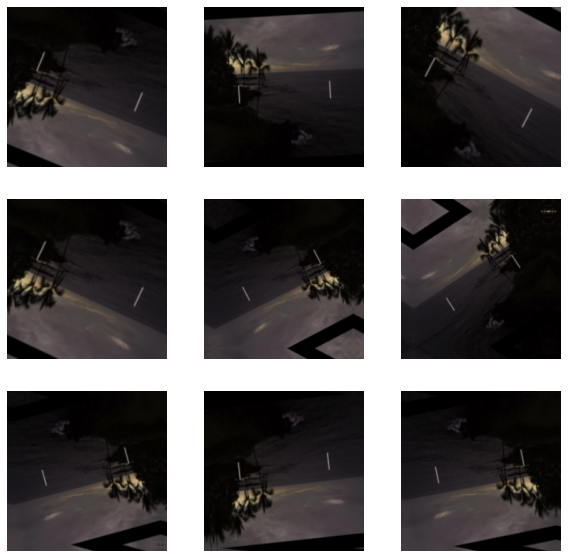

In [97]:
plt.figure(figsize=(10, 10)) 
for images, _ in dataset.take(1):   #sample N (1) batches from the dataset                        
    for i in range(9):
        print(images[0][0].shape)
        augmented_images = data_augmentation(images[0][0], training=True) # apply augmentation          
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images.numpy().astype("uint8"))   
        plt.axis("off")

In [98]:
labels_batch = labels[4]
frame_batch = videos[4]

# aug_frames, aug_labels = augment_using_ops(frame_batch, labels_batch)
# aug_frames_np = augment_numpy(frame_batch)

aug_video = data_augmentation(videos[4], training=True)
aug_video = aug_video.numpy().astype("uint8") #.shape

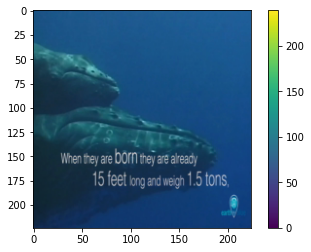

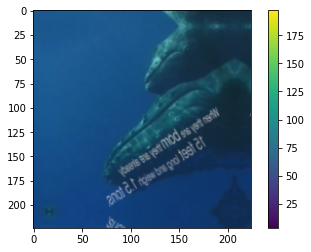

In [99]:
import matplotlib.pyplot as plt

idx =350

plt.figure()
plt.imshow(frame_batch[idx])
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure()
plt.imshow(aug_video[idx])
plt.colorbar()
plt.grid(False)
plt.show()

# plt.figure()
# plt.imshow(aug_frames[idx])
# plt.colorbar()
# plt.grid(False)
# plt.show()

# plt.figure()
# plt.imshow(aug_frames_np[idx])
# plt.colorbar()
# plt.grid(False)
# plt.show()



In [ ]:
#set up strategy and datasets
# strategy = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3', '/GPU:4', '/GPU:5', '/GPU:6', '/GPU:7'])

strategy = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3'])

print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Batch the input data
BUFFER_SIZE = videos.shape[0]
BATCH_SIZE_PER_REPLICA = 1
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Create Datasets from the batches
with tf.device("/device:CPU:0"):
#     dataset = tf.data.Dataset.from_tensor_slices((videos, labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels)).batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.prefetch(2)

# Create Distributed Datasets from the datasets
dist_dataset = strategy.experimental_distribute_dataset(dataset)

In [ ]:
# Create the model architecture
def create_model():
    feature_extractor = keras.applications.ResNet101(
                                                        weights      = 'imagenet',
                                                        include_top  = False,
                                                        pooling      = 'avg',
                                                        input_shape  = (224, 224, 3)
                                                    )

    preprocess_input = keras.applications.resnet.preprocess_input

    inputs = keras.Input((224, 224, 3)) #try making this 461, 224, 224, 3
#     inputs = data_augmentation(inputs, training=True)
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

# Create the model within the scope
with strategy.scope():
    model = create_model()
    
#######################
# Test Steps Functions
#######################
@tf.function
def distributed_test_step(dataset_inputs):
    return strategy.run(test_step, args=(dataset_inputs,)) #invoke function on each replica

def test_step(inputs):
    images, label = inputs
    
    #in the case that data does not divide evenly across GPUs,
    #TF creates a placeholder tensor so all GPUs have something to process
    #however this tensor will be empty and have shape (0, 461, 224, 224, 3) 
    #and simply not returning anything when the first dim is 0 gives us an AssertionError
    try:
        predictions = model(tf.squeeze(images), training=False)
        return predictions, label
    except ValueError:
        return None, None


In [ ]:
###############
# Feature Loop 
###############
print('Starting feature extraction...')
start = time.time()
features = []
labels_out = []
for batch in dist_dataset:
#     for _ in range(10): #simulate if dataset was 10x as big
    batch_features, batch_labels = distributed_test_step(batch)
    features.append(batch_features)
    labels_out.append(batch_labels)
stop = time.time()
print(f'Done extracting features in {stop-start} seconds')

In [ ]:
# turn PerReplica objects into list of tensors - multiGPU (8 GPU case, when number of videos doesnt divide evenly across GPUs)
# Replica:{0:<tensor>, 1:<feature-tensor>, 2:<feature-tensor>, 3:<feature-tensor>}
label_tensors = []
for replica_obj in labels_out:
    label_tensors += list(replica_obj.values) #convert tuple to list for += list operation

#converts list of tensors to list of label arrays
#final shape: (num_videos, 461, 2048)
labels_numpy = []
for tensor in label_tensors:
    if tensor is not None: #don't add empty tensors generated during data distribution
        labels_numpy.append(tensor.numpy())

#convert list to numpy format
labels_numpy = np.array(labels_numpy)

#print output shape
print(labels_numpy.shape)

# turn PerReplica objects into list of tensors
# Replica:{0:<tensor>, 1:<feature-tensor>, 2:<feature-tensor>, 3:<feature-tensor>}
feature_tensors = []
for replica_obj in features:
    feature_tensors += list(replica_obj.values) #convert tuple to list for += list operation

#converts list of tensors to list of frame features arrays
#final shape: (num_videos, 461, 2048)
features_numpy = []
for tensor in feature_tensors:
    if tensor is not None: #don't add empty tensors generated during data distribution
        features_numpy.append(tensor.numpy())

#convert list to numpy format
#these will be the input features for our CNN 
features_numpy = np.array(features_numpy)

#print output shape
print(features_numpy.shape)

In [15]:
# len(features)
# #Single GPU data formatting
# #converts list of tensors to list of label arrays
# #final shape: (num_videos, 461, 2048)
# labels_numpy = []
# for tensor in labels_out:
#     labels_numpy.append(tensor.numpy())

# #convert list to numpy format
# labels_numpy = np.array(labels_numpy)

# #print output shape
# print(labels_numpy.shape)

# #converts list of tensors to list of frame features arrays
# #final shape: (num_videos, 461, 2048)
# features_numpy = []
# for tensor in features:
#     features_numpy.append(tensor.numpy())

# #convert list to numpy format
# #these will be the input features for our CNN 
# features_numpy = np.array(features_numpy)

# #print output shape
# print(features_numpy.shape)

## Split Data after Multi-GPU Feature Extraction

In [ ]:
from sklearn.model_selection import train_test_split

X_0, X_test, y_0, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_0, y_0, test_size = 0.20, random_state = 42)

train_index = list(X_train.index)
test_index = list(X_test.index)
val_index = list(X_val.index)

train_features, train_labels = features_numpy[train_index], labels_numpy[train_index]
val_features, val_labels     = features_numpy[val_index], labels_numpy[val_index]
test_features, test_labels   = features_numpy[test_index], labels_numpy[test_index]

train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
val_labels = np.reshape(val_labels, (val_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

In [ ]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

In [ ]:
# Batch the input data
BUFFER_SIZE_TRAIN = train_features.shape[0]
BUFFER_SIZE_VAL = val_features.shape[0]
BUFFER_SIZE_TEST = test_features.shape[0]

BATCH_SIZE = 32

# Create Datasets from the batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(BUFFER_SIZE_TRAIN).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).shuffle(BUFFER_SIZE_VAL).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).shuffle(BUFFER_SIZE_TEST).batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(2)
val_dataset = val_dataset.prefetch(2)
test_dataset = test_dataset.prefetch(2)

## Split Data (single GPU Feature Extraction)

In [35]:
from sklearn.model_selection import train_test_split

X_0, X_test, y_0, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_0, y_0, test_size = 0.20, random_state = 42)

train_index = list(X_train.index)
test_index = list(X_test.index)
val_index = list(X_val.index)

train_features, train_labels = features[train_index], labels[train_index]
val_features, val_labels = features[val_index], labels[val_index]
test_features, test_labels = features[test_index], labels[test_index]

train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))
val_labels = np.reshape(val_labels, (val_labels.shape[0], 1))
test_labels = np.reshape(test_labels, (test_labels.shape[0], 1))

## Train RNN Model with Attention

In [ ]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))

        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [ ]:
# recurrent_dropout does not allow training to use cuDNN kernel
features_input       = keras.Input((461, 2048))
x                    = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(features_input)
x                    = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x                    = attention(return_sequences=False)(x)
x                    = Dropout(0.2)(x)
output               = keras.layers.Dense(2, activation="softmax")(x) #2 bc 2 class categories (0,1)
model                = keras.Model(features_input, output)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# my_callbacks    = [keras.callbacks.EarlyStopping(monitor="val_accuracy", 
#                                                  patience=3,
#                                                  mode="max",
#                                                  min_delta = 0.01,
#                                                  restore_best_weights=True)]
# # history = model.fit(train_features, 
#                     train_labels,
#                     validation_split = 0.2,
#                     epochs = 15,
#                     callbacks = my_callbacks,
#                     verbose= 1)


# print('Done training.')

# loss, accuracy = model.evaluate(test_features, test_labels)
# print(f"Test Metrics - Loss: {loss}, Accuracy: {accuracy}")

history = model.fit(train_dataset,
                    validation_data = val_dataset,
                    epochs = 15,
#                     callbacks = my_callbacks,
                    verbose= 1)


print('Done training.')

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Metrics - Loss: {loss}, Accuracy: {accuracy}")

`accuracy goes up to 82% with data augmentation and removing early stopping to train rnn for full 15 epochs`

## Trying to Distribute Data + Run RNN Model

In [19]:
# strategy = tf.distribute.MirroredStrategy()

# global_batch_size = 91*4
# dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(global_batch_size)
# dist_dataset = strategy.experimental_distribute_dataset(dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2022-07-25 23:17:29.071859: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 291
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1273"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 461
        }
        dim {
          size: 2048
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_P

In [23]:
#training runs successfully when we specify just the first 3 GPUs (IDs 0,1,2)
#once we add in GPU:3, we get a CUDNN_STATUS_BAD_PARAM error
strategy = tf.distribute.MirroredStrategy(['/GPU:3'])

with strategy.scope():
    features_input       = keras.Input((461, 2048))
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(features_input)
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(x)
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(x)
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)

    output               = keras.layers.Dense(2, activation="softmax")(x) #2 bc 2 class categories (0,1)
    model                = keras.Model(features_input, output)

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_features,
                    train_labels,
                    epochs = 10,
                    verbose= 1)

print('Done training.')

loss, accuracy = model.evaluate(test_features, test_labels)
print(f"Test Metrics - Loss: {loss}, Accuracy: {accuracy}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3',)
Epoch 1/10


2022-07-27 18:52:09.461372: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_438939"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1215"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

10/10 [==============================] - 24s 168ms/step - loss: 0.6002 - accuracy: 0.6838
Epoch 2/10
10/10 [==============================] - 2s 156ms/step - loss: 0.4380 - accuracy: 0.8144
Epoch 3/10
10/10 [==============================] - 2s 158ms/step - loss: 0.3579 - accuracy: 0.8385
Epoch 4/10
10/10 [==============================] - 2s 159ms/step - loss: 0.2598 - accuracy: 0.8969
Epoch 5/10
10/10 [==============================] - 2s 161ms/step - loss: 0.1619 - accuracy: 0.9450
Epoch 6/10
10/10 [==============================] - 2s 161ms/step - loss: 0.1263 - accuracy: 0.9553
Epoch 7/10
10/10 [==============================] - 2s 163ms/step - loss: 0.0747 - accuracy: 0.9759
Epoch 8/10
10/10 [==============================] - 2s 162ms/step - loss: 0.0464 - accuracy: 0.9828
Epoch 9/10
10/10 [==============================] - 2s 151ms/step - loss: 0.1414 - accuracy: 0.9416
Epoch 10/10
10/10 [==============================] - 1s 147ms/step - loss: 0.0721 - accuracy: 0.9794
Done trai

2022-07-27 18:52:48.197125: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_456275"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1266"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

3/3 [==============================] - 6s 79ms/step - loss: 0.6300 - accuracy: 0.8082
Test Metrics - Loss: 0.6300287246704102, Accuracy: 0.8082191944122314


## Coursera Multi-GPU Strategy
Resources
- https://www.coursera.org/learn/custom-distributed-training-with-tensorflow/lecture/21zgD/multi-gpu-mirrored-strategy-code-walkthrough
- https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Custom%20and%20Distributed%20Training%20with%20Tensorflow/Week%204%20-%20Distributed%20Training/C2_W4_Lab_2_multi-GPU-mirrored-strategy.ipynb

In [ ]:
train_features.shape

In [ ]:
import tensorflow as tf
import numpy as np
import os
# Note that it generally has a minimum of 8 cores, but if your GPU has
# less, you need to set this. In this case one of my GPUs has 4 cores
# os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "4"

# If the list of devices is not specified in the
# `tf.distribute.MirroredStrategy` constructor, it will be auto-detected.
# If you have *different* GPUs in your system, you probably have to set up cross_device_ops like this
# strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
strategy = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1', '/GPU:2', '/GPU:3', '/GPU:4', '/GPU:5', '/GPU:6', '/GPU:7'])
# strategy = tf.distribute.MirroredStrategy()
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Batch the input data
BUFFER_SIZE_TRAIN = train_features.shape[0]
BUFFER_SIZE_TEST = test_features.shape[0]
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Create Datasets from the batches
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(BUFFER_SIZE_TRAIN).batch(GLOBAL_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).shuffle(BUFFER_SIZE_TEST).batch(GLOBAL_BATCH_SIZE)

train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)

# Create Distributed Datasets from the datasets
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

# Create the model architecture
def create_model():
#     features_input       = keras.Input((461, 2048))
#     x                    = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True, recurrent_dropout=0.1, unroll=True))(features_input)
#     x                    = keras.layers.Bidirectional(keras.layers.LSTM(32, recurrent_dropout=0.1, unroll=True))(x)

#     output               = keras.layers.Dense(2)(x) #2 bc 2 class categories (0,1)
#     model                = keras.Model(features_input, output)
#     return model

    features_input       = keras.Input((461, 2048))
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(features_input)
    x                    = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
    x                    = attention(return_sequences=False)(x)
    x                    = Dropout(0.2)(x)
    output               = keras.layers.Dense(2, activation="softmax")(x) #2 bc 2 class categories (0,1)
    model                = keras.Model(features_input, output)
    return model

# Instead of model.compile, we're going to do custom training, so let's do that
# within a strategy scope
with strategy.scope():

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions):
        per_example_loss = loss_object(labels, predictions)
        print(per_example_loss)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    # We'll just reduce by getting the average of the losses
    test_loss = tf.keras.metrics.Mean(name='test_loss')

    # Accuracy on train and test will be SparseCategoricalAccuracy
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

    # Optimizer will be Adam
    optimizer = tf.keras.optimizers.Adam()

    # Create the model within the scope
    model = create_model()


###########################
# Training Steps Functions
###########################

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    #tf.print(per_replica_losses.values)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

def train_step(inputs):
    images, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)
    return loss

#######################
# Test Steps Functions
#######################
@tf.function
def distributed_test_step(dataset_inputs):
    return strategy.run(test_step, args=(dataset_inputs,))

def test_step(inputs):
    images, labels = inputs

    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss.update_state(t_loss)
    test_accuracy.update_state(labels, predictions)


###############
# TRAINING LOOP
###############

EPOCHS = 10
for epoch in range(EPOCHS):
    # Do Training
    total_loss = 0.0
    num_batches = 0
    for batch in train_dist_dataset:
        total_loss += distributed_train_step(batch)
        num_batches += 1
    train_loss = total_loss / num_batches

    # Do Testing
    for batch in test_dist_dataset:
        distributed_test_step(batch)

    template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, " "Test Accuracy: {}")

    print (template.format(epoch+1, train_loss, train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))

    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 8


2022-07-29 16:44:02.293794: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 291
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:856"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 461
        }
        dim {
          size: 2048
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2022-07-29 16:44:02.614581: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 73
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:859"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 461
        }
        dim {
          size: 2048
        }
      }
      shape {
        dim {
          size: 1
        }
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(32,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
Tensor("replica_1/sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(32,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:1)
Tensor("replica_2/sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(32,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:2)
Tensor("replica_3/sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(32,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:3)


## WandB Metrics

In [14]:
#log training and validation metrics on wandb
for epoch, train_loss in enumerate(history.history['loss']):
    wandb.log({'training_loss': train_loss, "epoch": epoch})
    
for epoch, train_acc in enumerate(history.history['accuracy']):
    wandb.log({'training_accuracy': train_acc, "epoch": epoch})
    
for epoch, val_loss in enumerate(history.history['val_loss']):
    wandb.log({'val_loss': val_loss, "epoch": epoch})
    
for epoch, val_acc in enumerate(history.history['val_accuracy']):
    wandb.log({'val_accuracy': val_acc, "epoch": epoch})
    
print('Done Logging WandB metrics.')

Done Logging WandB metrics.


In [14]:
wandb.finish()